In [ ]:
# install all depedencies
# a GPU is needed, so run this notebook in a cuda working environment

!pip install -r ./src/requirements.txt

### DEEP Assisted Tagging Tool


In this notebook we propose an example of the main model architecture for the assisted tagging tool that will soon be implemented in [**The DEEP**](https://thedeep.io/) platform.

Let's recap for completeness what The DEEP is, and how Machine Learning models improve its use. 

The DEEP is a collaborative platform for qualitative data analysis supporting humanitarian analytical teams to produce actionable insights. Since its inception in the aftermath of the 2015 Nepal Earthquake, DEEP has significantly contributed to improving the humanitarian data ecosystem, and today, without a doubt, is the largest repository of annotated humanitarian response documents: 50k+ sources/leads and 400k+ entries, used for 300+ projects by 3.5k+ registered users in 60+ countries.

During crises, rapidly identifying important information from available data (news, reports, research, etc.) is crucial to understanding the needs of affected populations and to improving evidence-based decision-making. To make the information classification process even faster, DEEP is largely benefitting from  Natural Language Processing (NLP) and Deep Learning (DL) to aid and support the manual tagging process and give the humanitarian community more time to produce analyses and take rapid action to save more lives.

Up to now, all the information (of any kind: reports, news, articles, maps, infographics, etc.) uploaded to the platform has been annotated by hand by experts in the humanitarian sector. The tagging was done under several projects according to different predefined multi-label categories (analytical frameworks). Since the data is mostly textual, we internally developed NLP models that could improve and speed up the analysis of the texts. 

We must also consider that informations are often contained within document reports (PDF, docx etc.) of numerous pages, making the tagging effort very difficult and time-consuming, therefore we understand how important it can be to optimize the humanitarian response during, for example, an ongoing natural disaster.

### Data

Let's go into the details of the model now, starting from the data.

In The DEEP platform each user or group has the possibility to create a project, which is usually link to a certain humanitarian crisis, such as a natural disaster, or to a certain geographic region or state where a rapid response is needed. Users can create custom labels and use them to annotate the information that will be uploaded within each project. Therefore each user will have the possibility to upload, for example, a document (of any format), select an exerpt of text (which perhaps contains important details for the purpose of the analysis) and annotate it using its own project labels. 

To combine entries from those projects and various analytical frameworks (set of labels), we defined a generic analytical framework and we transformed our labels accordingly. Our generic analytical framework has 10 different multi-label categories, totalling 86 different labels, covering all areas of a detailed humanitarian analysis.

Our proposed dataset contains 8 categories overall:
- 3 **primary tags**: sectors, pillars/subpillars_2d, pillars/subpillars_1d
- 5 **secondary tags**: affected_groups, demographic_groups, specific_needs_groups, severity, geolocation

Different tags are treated independently one from another. One model is trained alone for each different tag.

In this notebook we focus only on a subset of above categories, **primary tags**.
Primary tags contain 75 labels under different subcategories named as follows: 
- **Sectors** with 11 labels,
- **2D Pillars** with  6 labels,
- **2D Sub-pillars** with  18 labels,
- **1D Pillars** with  7 labels,
- **1D Sub-pillars** with  33 labels

Let's see how they are divided:

<div> <center><img src="./img/plot1.png" alt="Drawing" style="width: 1500px;"/></center></div> 

We can see that, apart from Sectors, each subcategory has an annotation hierarchy, from Pillar to Sub-pillar (1D and 2D) . Furthermore, each text excerpt can be annotated with multiple labels, thus making the problem a multi-label text classification.

The difference between 1D and 2D Pillars (and respective Sub-pillars), as we can see in the previous image, lies in the fact that the 2D subcategory presents an additional level of hierarchy, given by the Sectors. Example:

<div> <center><img src="./img/ex.png" alt="Drawing" style="width: 1400px;"/></center></div> 

#### Get Data

In [1]:
from src.dowload_dataset import download_file_from_google_drive

# download public data from google drive

TRAIN_VAL_ID = "1W9-IN0DgYYsiwrWi9Aefyc1V87_q_LWd"
TEST_ID = "11NQCwixCW2ZiFlSp1QNen2uiS2gThu2B"

# set files path for training and testing set
TRAIN_VAL_NAME = "train_val_dataset.csv"
TEST_NAME = "test_dataset.csv"

# downloading
download_file_from_google_drive(id=TRAIN_VAL_ID, destination=TRAIN_VAL_NAME)
download_file_from_google_drive(id=TEST_ID, destination=TEST_NAME)

### Data:

In [20]:
import pandas as pd

important_columns = ['entry_id', 'project_id', 'lead_id', 'analysis_framework_id', 'excerpt', 'sectors', 'subpillars_1d', 'subpillars_2d', 'lang']

dataset = pd.read_csv(TEST_NAME)[important_columns]
nb_samples = dataset.shape[0]
print(f'We have {nb_samples} samples')

We have 10420 samples


In [12]:
from ast import literal_eval

classification_columns = ['sectors', 'subpillars_1d', 'subpillars_2d']
for col in classification_columns:
    dataset[col] = dataset[col].apply(literal_eval)

In [18]:
# explore the data
dataset.head()

,entry_id,project_id,lead_id,analysis_framework_id,excerpt,sectors,subpillars_1d,subpillars_2d,lang
0,489433,2225.0,67488.0,1306.0,Primary and secondary net enrollment rates are...,[Education],[Context->Socio Cultural],[Humanitarian Conditions->Living Standards],en
1,489430,2225.0,67488.0,1306.0,"Like few other countries globally, the majorit...",[],[Context->Socio Cultural],[],en
2,489438,2225.0,67488.0,1306.0,And the policy is already having significant i...,[Education],[Context->Socio Cultural],"[Impact->Impact On Systems, Services And Netwo...",en
3,187423,2170.0,43202.0,1306.0,"[9thNov 2020,Nigeria]With the latest update, N...",[],[Covid-19->Cases],[],en
4,489437,2225.0,67488.0,1306.0,"But almost 2 years on, it is safe to say that ...",[Education],[Context->Socio Cultural],"[Capacities & Response->National Response, Imp...",en


Text(0.5, 1.0, 'piechart of languages present in dataset')

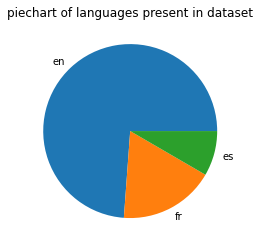

In [26]:
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

language_counts = dict(Counter(dataset.lang))
plt.pie(list(language_counts.values()), labels=list(language_counts.keys()))
plt.title('piechart of languages present in dataset')

Textual entries are in 3 different languages: **English (mainly)**, **Spanish** and **French**.

In [19]:
def flatten(t):
    return [item for sublist in t for item in sublist]

merged_tags = flatten(
    dataset.apply(lambda x: x.sectors + x.subpillars_1d + x.subpillars_2d, axis=1)
)
total_nb_tags = len(set(merged_tags))

print(f'We have a total of {total_nb_tags} tags')

We have a total of 57 tags


In [31]:
from scipy.stats import entropy
import numpy as np

nb_occurences_each_tag = dict(Counter(merged_tags))
probability_occurence_each_tag = {tag_name: 100 * number_of_occurences/nb_samples for tag_name, number_of_occurences in nb_occurences_each_tag.items()}
print(f'The Shannon Entropy of the tags is: {np.round(entropy(list(probability_occurence_each_tag.values())), 2)}')

The Shannon Entropy of the tags is: 3.48


Text(0.5, 1.0, 'boxplot of probability of occurences for each tag')

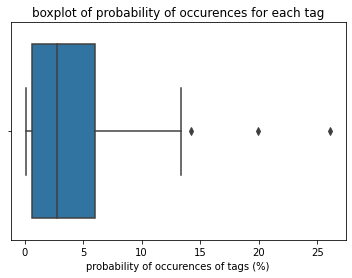

In [33]:
sns.boxplot(x=list(probability_occurence_each_tag.values()))
plt.xlabel('probability of occurences of tags (%)')
plt.title('boxplot of probability of occurences for each tag')

**Conclusions about Data**: 
* Multilingual Data
* many tags to be handled
* Imbalanced repartition of tags with some tags nearly absent

**Implemented Ways to augment data**:
1) Basic Data augmentation techniques (random swapping, random deletion etc.)  
2) Data augmentation with translation  
3) Targetted Data Augmentation (augment text containing number-related tags by changing numbers)  

$\rightarrow$ Option 2 improved results, while options 1 and 3 did not show any improvement in results

**Data Splitting**:
- We create a unified training and testing data to be able to have a clear understanding of models performance.
- We use stratified splitting, which keeps the same labels proportions in both the train and the test set.

### **Model**

#### *I. Model specifications*:
The model developed is based on pre-trained transformer architecture. The transformer had to fulfill some criteria:
- **multilingual** : it needs to work for different languages
- **good performance** : in order for it to be useful, the model needs to be performant
- **fast predictions** : the main goal of the modelling is to give live predictions to taggers while they are working on tagging. Speed is critical in this case and the faster the model the better.
- **ability to handle important number of imbalanced tags** : The model needs to be able to adapt to data specificities: many tags which are not represented the same way.
- **one endpoint only for deployment**: in order to optimize costs, we want to have one endpoint only for all models and predictions. To do this, we create one custom class containing models and deploy it.

#### *II. model training*

- **backbone**: We use the transformer [**microsoft/xtremedistil-l6-h256-uncased**](https://huggingface.co/microsoft/xtremedistil-l6-h256-uncased) as a backbone.
  
- **trained models**: In this notebook we overall train three independent models: `sectors`, one for `subpillars (1D and 2D)` and one for `secondary tags`. 
    - *`sectors` model training*: `sectors` is trained with a MLP-like standard architecture.
    - *other models training: `subpillars` and one for `secondary tags`*: we use tree-like multi-task learning models, fine-tuning the last hidden state of the transformer differently for each subtask. The 5 first hidden layers from the backbone are common to all the tasks and the last hidden layer is specific to each task.  
    <br>


- **multi-task learning models**: 
    - `subpillars`: Each subtask corresponds to one different pillar $\rightarrow$ We have 13 different sub-tasks for a total of 51 different tags.
    - `secondary tags` we don't have a hierarchy, so the submodel is only a multi-task architecture $\rightarrow$ We have 5 different tasks
    - *benefits*:
        - Share the encoding information, obtained from our transformer backbone, and then train different heads separately for different tasks
        - Further anneal the problems due to data imbalance
        - Deal with a big number of different tags in single models
    
<!-- We have 13 different subtasks for the subpillars model (Humanitarian Conditions, At Risk, Displacement, Covid-19, Humanitarian Access, Impact, Information And Communication, Shock/Event, Capacities & Response, Context, Casualties, Priority Interventions, Priority Needs) each of which then has its own final labels, which we want to predict. -->

- **threshold tuning**: 
    - *objective: 
    1) After training the models on the training set we generate logit predictions on the vlidation set.  
    2) and to optimize our results, we hypertune the threshold for each label to optimize the f1 score on the validation set. Therefore, each different label has a different threshold. This keeps the models from overtagging and helps adapt to the data imbalanceness problem.

<div> <center><img src="./img/model.png" alt="Drawing" style="width: 600px;"/></center></div> 
<!-- ![image info](./img/model.png) -->


Now let's get started with the serious stuff ;)

In [ ]:
# we use pytorch and pytorch-lightning as main frameworks

import torch
import copy, os
import numpy as np
import torch.nn.functional as F
import pytorch_lightning as pl


from typing import Optional, List
from tqdm.auto import tqdm
from sklearn import metrics
from transformers import AutoModel, AutoTokenizer
from torch.utils.data import DataLoader
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from torch.optim.lr_scheduler import ReduceLROnPlateau
from transformers import AdamW

# importing some utilities methods
from src.utils import *
# loss
from src.loss import FocalLoss
# encoder embeddings pooling module
from src.pooling import Pooling
# pytorch Dataset custom dataset builder
from src.data import CustomDataset

In [ ]:
# this is the classifier architecture

class Model(torch.nn.Module):
    
    def __init__(
        self,
        model_name_or_path: str,
        ids_each_level,
        dropout_rate=0.3,
        output_length=384,
        dim_hidden_layer: int = 256,
    ):
        super().__init__()
        
        self.ids_each_level = ids_each_level
        self.l0 = AutoModel.from_pretrained(model_name_or_path)
        self.pool = Pooling(word_embedding_dimension=output_length, pooling_mode="cls")

        self.LayerNorm_backbone = torch.nn.LayerNorm(output_length)
        self.LayerNorm_specific_hidden = torch.nn.LayerNorm(dim_hidden_layer)

        self.dropout = torch.nn.Dropout(dropout_rate)

        self.specific_hidden_layer = torch.nn.ModuleList([
            torch.nn.Linear(output_length, dim_hidden_layer) for _ in ids_each_level
        ])

        self.output_layer = torch.nn.ModuleList([
            torch.nn.Linear(dim_hidden_layer, len(id_one_level))
            for id_one_level in ids_each_level
        ])
    
    def forward(self, inputs):
        
        """
        Multi-task forward.
        
        """
        
        output = self.l0(
            inputs["ids"],
            attention_mask=inputs["mask"],
        )
        output = self.pool(
            {
                "token_embeddings": output.last_hidden_state,
                "attention_mask": inputs["mask"],
            }
        )["sentence_embedding"]

        last_hidden_states = [output.clone() for _ in self.ids_each_level]

        heads = []
        for i in range(len(self.ids_each_level)):
            # specific hidden layer
            output_tmp = F.selu(last_hidden_states[i])
            output_tmp = self.dropout(output_tmp)
            output_tmp = self.LayerNorm_specific_hidden(output_tmp)

            # output layer
            output_tmp = self.output_layer[i](output_tmp)
            heads.append(output_tmp)

        return heads

In [ ]:
# pytorch-lightining model class
# as loss we use a BCE focal loss (details in ./src/loss.py)

class Transformer(pl.LightningModule):
    
    def __init__(
        self,
        model_name_or_path: str,
        train_dataset,
        val_dataset,
        train_params,
        val_params,
        tokenizer,
        column_name,
        multiclass,
        learning_rate: float = 1e-5,
        adam_epsilon: float = 1e-7,
        warmup_steps: int = 500,
        weight_decay: float = 0.1,
        train_batch_size: int = 32,
        eval_batch_size: int = 32,
        dropout_rate: float = 0.3,
        max_len: int = 512,
        output_length: int = 384,
        training_device: str = "cuda",
        keep_neg_examples: bool = False,
        dim_hidden_layer: int = 256,
        **kwargs,
    ):

        super().__init__()
        self.output_length = output_length
        self.column_name = column_name
        self.save_hyperparameters()
        self.targets = train_dataset["target"]
        self.tagname_to_tagid = tagname_to_id(train_dataset["target"])
        self.num_labels = len(self.tagname_to_tagid)
        self.get_first_level_ids()

        self.max_len = max_len
        self.model = Model(
            model_name_or_path,
            self.ids_each_level,
            dropout_rate,
            self.output_length,
            dim_hidden_layer,
        )
        self.tokenizer = tokenizer
        self.val_params = val_params

        self.training_device = training_device

        self.multiclass = multiclass
        self.keep_neg_examples = keep_neg_examples

        self.training_loader = self.get_loaders(
            train_dataset, train_params, self.tagname_to_tagid, self.tokenizer, max_len
        )
        self.val_loader = self.get_loaders(
            val_dataset, val_params, self.tagname_to_tagid, self.tokenizer, max_len
        )
        self.Focal_loss = FocalLoss()

    def forward(self, inputs):
        output = self.model(inputs)
        return output

    def training_step(self, batch, batch_idx):
        outputs = self(batch)
        train_loss = self.get_loss(outputs, batch["targets"])

        self.log(
            "train_loss", train_loss.item(), prog_bar=True, on_step=False, on_epoch=True
        )
        return train_loss

    def validation_step(self, batch, batch_idx):
        outputs = self(batch)
        val_loss = self.get_loss(outputs, batch["targets"])
        self.log(
            "val_loss",
            val_loss,
            on_step=False,
            on_epoch=True,
            prog_bar=True,
            logger=False,
        )

        return {"val_loss": val_loss}

    def configure_optimizers(self):
        "Prepare optimizer and schedule (linear warmup and decay)"

        optimizer = AdamW(
            self.parameters(),
            lr=self.hparams.learning_rate,
            weight_decay=self.hparams.weight_decay,
            eps=self.hparams.adam_epsilon,
        )

        scheduler = ReduceLROnPlateau(
            optimizer, "min", 0.5, patience=self.hparams.max_epochs // 6
        )
        scheduler = {
            "scheduler": scheduler,
            "interval": "epoch",
            "frequency": 1,
            "monitor": "val_loss",
        }
        return [optimizer], [scheduler]

    def train_dataloader(self):
        return self.training_loader

    def val_dataloader(self):
        return self.val_loader

    def get_loaders(
        self, dataset, params, tagname_to_tagid, tokenizer, max_len: int = 128
    ):

        set = CustomDataset(dataset, tagname_to_tagid, tokenizer, max_len)
        loader = DataLoader(set, **params, pin_memory=True)
        return loader

    def get_loss(self, outputs, targets, only_pos: bool = False):
        """
        INPUTS:
            - outputs: raw outputs of model: List[List[float]]
            - targets: groundtruth: List[int]
            - only_pos: if True: do not do backpropagation for negative samples 
            (Negative samples are rows which do not contain any subatg)
        OUTPUTS:
            loss
        """
        
        if len(self.ids_each_level) == 1:
            return self.Focal_loss(outputs[0], targets)
        else:
            tot_loss = 0
            for i_th_level in range(len(self.ids_each_level)):
                ids_one_level = self.ids_each_level[i_th_level]
                outputs_i_th_level = outputs[i_th_level]
                targets_one_level = targets[:, ids_one_level]
                
                # main objective: for each level, if row contains only zeros, not to do backpropagation

                if only_pos:
                    mask_ids_neg_example = [
                        not bool(int(torch.sum(one_row)))
                        for one_row in targets_one_level
                    ]
                    outputs_i_th_level[mask_ids_neg_example, :] = 1e-8

                tot_loss += self.Focal_loss(outputs_i_th_level, targets_one_level)

            return tot_loss

    def get_first_level_ids(self):
        """
        function used to get different tasks and levels of classification
            - What characterizes multitask data from non multitask data is the presence of the arrow '->'
            Therefore, use it as characterization for multitask or not.
            - When having a multitask scenario, we return a list of lists for ids
            Example: We have 3 different tasks, each containing 2 subtasks
            The output would be [[0, 1], [2, 3], [4, 5]]
            This will be used later in models to get ids of each specific task.
        """
        all_names = list(self.tagname_to_tagid.keys())
        if np.all(["->" in name for name in all_names]):
            first_level_names = list(
                np.unique([name.split("->")[0] for name in all_names])
            )
            self.ids_each_level = [
                [i for i in range(len(all_names)) if name in all_names[i]]
                for name in first_level_names
            ]

        else:
            self.ids_each_level = [[i for i in range(len(all_names))]]

    def custom_predict(
        self, validation_dataset, testing=False, hypertuning_threshold: bool = False
    ):
        """
        1) get raw predictions
        2) postprocess them to output an output compatible with what we want in the inference
        """

        def sigmoid(x):
            return 1 / (1 + np.exp(-x))

        if testing:
            self.val_params["num_workers"] = 0

        validation_loader = self.get_loaders(
            validation_dataset,
            self.val_params,
            self.tagname_to_tagid,
            self.tokenizer,
            self.max_len,
        )

        if torch.cuda.is_available():
            testing_device = "cuda"
        else:
            testing_device = "cpu"

        self.to(testing_device)
        self.eval()
        self.freeze()
        y_true = []
        logit_predictions = []
        indexes = []

        with torch.no_grad():
            for batch in tqdm(
                validation_loader,
                total=len(validation_loader.dataset) // validation_loader.batch_size,
            ):

                if not testing:
                    y_true.append(batch["targets"].detach())
                    indexes.append(batch["entry_id"].detach())

                logits = self(
                    {
                        "ids": batch["ids"].to(testing_device),
                        "mask": batch["mask"].to(testing_device),
                        "token_type_ids": batch["token_type_ids"].to(testing_device),
                    }
                )
                logits = torch.cat(logits, dim=1)  # have a matrix like in the beginning
                logits_to_array = np.array([np.array(t) for t in logits.cpu()])
                logit_predictions.append(logits_to_array)

        logit_predictions = np.concatenate(logit_predictions)
        logit_predictions = sigmoid(logit_predictions)

        target_list = list(self.tagname_to_tagid.keys())
        probabilities_dict = []
        # postprocess predictions
        for i in range(logit_predictions.shape[0]):

            # Return predictions
            row_logits = logit_predictions[i, :]

            # Return probabilities
            probabilities_item_dict = {}
            for j in range(logit_predictions.shape[1]):
                if hypertuning_threshold:
                    probabilities_item_dict[target_list[j]] = row_logits[j]
                else:
                    probabilities_item_dict[target_list[j]] = (
                        row_logits[j] / self.optimal_thresholds[target_list[j]]
                    )

            probabilities_dict.append(probabilities_item_dict)

        if not testing:
            y_true = np.concatenate(y_true)
            indexes = np.concatenate(indexes)
            return indexes, logit_predictions, y_true, probabilities_dict

        else:
            return probabilities_dict

    def hypertune_threshold(self, beta_f1: float = 0.8):
        """
        having the probabilities, loop over a list of thresholds to see which one:
        1) yields the best results
        2) without being an aberrant value (we use a runinng ean)
        """

        data_for_threshold_tuning = self.val_loader.dataset.data
        indexes, logit_predictions, y_true, _ = self.custom_predict(
            data_for_threshold_tuning, hypertuning_threshold=True
        )

        thresholds_list = np.linspace(0.0, 1.0, 101)[::-1]
        optimal_thresholds_dict = {}
        optimal_scores = []
        for ids_one_level in self.ids_each_level:
            y_true_one_level = y_true[:, ids_one_level]
            logit_preds_one_level = logit_predictions[:, ids_one_level]

            for j in range(len(ids_one_level)):
                scores = []
                for thresh_tmp in thresholds_list:
                    metric = self.get_metric(
                        logit_preds_one_level[:, j],
                        y_true_one_level[:, j],
                        beta_f1,
                        thresh_tmp,
                    )
                    scores.append(metric)

                max_threshold = 0
                max_score = 0
                for i in range(1, len(scores) - 1):
                    # take running mean to have smoother results
                    score = np.mean(scores[i - 1 : i + 2])
                    if score >= max_score:
                        max_score = score
                        max_threshold = thresholds_list[i]

                optimal_scores.append(max_score)

                optimal_thresholds_dict[
                    list(self.tagname_to_tagid.keys())[ids_one_level[j]]
                ] = max_threshold

        self.optimal_thresholds = optimal_thresholds_dict

        return np.mean(optimal_scores)

    def get_metric(self, preds: List[float], groundtruth: List[int], beta_f1: float, threshold_tmp: float):
        """
        INPUTS:
            - preds: list of all probabilities for one specific subtag
            - groundtruth: list of all predictions for one specific subtag
            - beta_f1: beta value used for computing the beta f1 score
            - threshold_tmp: threshold tested
        
        OUTPUTS:
            - f1 / beta_f1 score for specific subtag for specific threshold
        """

        column_pred = [
            1 if one_logit > threshold_tmp else 0 for one_logit in preds
        ]

        if self.multiclass:
            metric = metrics.fbeta_score(
                groundtruth,
                column_pred,
                beta_f1,
                average='binary', 
                pos_label=1
            )
        else:
            metric = metrics.f1_score(
                groundtruth,
                column_pred,
                average='binary', 
                pos_label=1
            )
        return metric

In [ ]:
# main class used to train model
    
class CustomTrainer:


    def __init__(
        self,
        train_dataset,
        val_dataset,
        training_column,
        MODEL_DIR: str,
        MODEL_NAME: str,
        TOKENIZER_NAME: str,
        dropout_rate: float,
        train_params,
        val_params,
        gpu_nb: int,
        MAX_EPOCHS: int,
        weight_decay=0.02,
        warmup_steps=500,
        output_length=384,
        max_len=150,
        multiclass_bool=True,
        keep_neg_examples_bool=False,
        learning_rate=3e-5,
        weighted_loss: str = "sqrt",
        training_device: str = "cuda",
        beta_f1: float = 0.8,
        dim_hidden_layer: int = 256
    ) -> None:
        
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset
        self.training_column = training_column
        self.MODEL_DIR = MODEL_DIR
        self.MODEL_NAME = MODEL_NAME
        self.TOKENIZER_NAME = TOKENIZER_NAME
        self.dropout_rate = dropout_rate
        self.train_params = train_params
        self.val_params = val_params
        self.gpu_nb = gpu_nb
        self.MAX_EPOCHS = MAX_EPOCHS
        self.weight_decay = weight_decay
        self.warmup_steps = warmup_steps
        self.output_length = output_length
        self.max_len = max_len
        self.multiclass_bool = multiclass_bool
        self.keep_neg_examples_bool = keep_neg_examples_bool
        self.learning_rate = learning_rate
        self.weighted_loss = weighted_loss
        self.training_device = training_device
        self.beta_f1 = beta_f1
        self.dim_hidden_layer = dim_hidden_layer

    def train_model(self):
        PATH_NAME = self.MODEL_DIR
        if not os.path.exists(PATH_NAME):
            os.makedirs(PATH_NAME)

        early_stopping_callback = EarlyStopping(
            monitor="val_loss", patience=2, mode="min"
        )

        checkpoint_callback_params = {
            "save_top_k": 1,
            "verbose": True,
            "monitor": "val_loss",
            "mode": "min",
        }

        FILENAME = "model_" + self.training_column
        dirpath_pillars = str(PATH_NAME)
        checkpoint_callback = ModelCheckpoint(
            dirpath=dirpath_pillars, filename=FILENAME, **checkpoint_callback_params
        )

        logger = TensorBoardLogger("lightning_logs", name=FILENAME)

        trainer = pl.Trainer(
            logger=logger,
            callbacks=[early_stopping_callback, checkpoint_callback],
            progress_bar_refresh_rate=40,
            profiler="simple",
            log_gpu_memory=True,
            weights_summary=None,
            gpus=self.gpu_nb,
            precision=16,
            accumulate_grad_batches=1,
            max_epochs=self.MAX_EPOCHS,
            gradient_clip_val=1,
            gradient_clip_algorithm="norm"
        )
        
        tokenizer = AutoTokenizer.from_pretrained(self.TOKENIZER_NAME)
        
        model = Transformer(
            model_name_or_path=self.MODEL_NAME,
            train_dataset=self.train_dataset,
            val_dataset=self.val_dataset,
            train_params=self.train_params,
            val_params=self.val_params,
            tokenizer=tokenizer,
            column_name=self.training_column,
            gpus=self.gpu_nb,
            plugin="deepspeed_stage_3_offload",
            accumulate_grad_batches=1,
            max_epochs=self.MAX_EPOCHS,
            dropout_rate=self.dropout_rate,
            weight_decay=self.weight_decay,
            warmup_steps=self.warmup_steps,
            output_length=self.output_length,
            learning_rate=self.learning_rate,
            multiclass=self.multiclass_bool,
            weighted_loss=self.weighted_loss,
            training_device=self.training_device,
            keep_neg_examples=self.keep_neg_examples_bool,
            dim_hidden_layer=self.dim_hidden_layer
        )

        trainer.fit(model)
        model.train_f1_score = model.hypertune_threshold(self.beta_f1)

        #delete data from models
        del model.training_loader
        del model.val_loader

        return model

In [ ]:
# columns selection to train
# here we train only primary tags: sectors and pillars/sub-pillars (1D & 2D)

columns = [
    'excerpt', 
    'entry_id', 
    'subpillars', 
    'sectors' 
    #'secondary_tags' we don't train secondary tags here 
    ]

In [ ]:
hyp = {  
    "epochs": 2,
    "train_batch_size": 32,
    "val_batch_size": 32,
    "max_len": 512,
    "warmup_steps": 10,
    "learning_rate": 3e-5,
    "output_length": 256,
    "nb_repetitions": 1,
    "model_name":  "microsoft/xtremedistil-l6-h256-uncased",
    "tokenizer_name": "microsoft/xtremedistil-l6-h256-uncased",
    "beta_f1": 0.7,   
    "n_gpu": 1,
    # set a directory name for trianed-models checkpoints
    "model_dir": "./models",
}

In [ ]:
def run_training(dataset, training_columns, hyperparaments):
        
    models = {}
    
    train_params = {
        "batch_size": hyperparaments["train_batch_size"],
        "shuffle": True,
        "num_workers": 4
    }
    
    val_params = {
        "batch_size": hyperparaments["val_batch_size"],
        "shuffle": False,
        "num_workers": 4
    }
    
    if torch.cuda.is_available():
        gpu_nb = 1
        training_device = "cuda"
    else:
        gpu_nb = 0
        training_device = "cpu"
        
    print(f"Training device: {training_device}")
        
    for column in training_columns[2:]:
        
        #only for the severity tag, we have single label classification
        multiclass_bool = column != "severity"
        keep_neg_examples = True
        
        best_score = 0
        iter_nb = 0

        while best_score < 0.3 and iter_nb < hyperparaments["nb_repetitions"]:

            train_df, val_df = preprocess_df(
                dataset, column, multiclass_bool, keep_neg_examples
            )
            print(f"Data pre-processing. Train: {len(train_df)}, Validation: {len(val_df)}")
            
            # for the purpose of our sample notebook we select a minimal number of epochs
            max_epochs = 1

            #depending on the training data size, we have different optimal training parameters
            if len(train_df) > 120_000:
                dropout_column = 0.2
                weight_decay_col = 1e-3
                dim_hidden_layer = 256
                # max_epochs = 5
                learning_rate = 8e-5

            elif len(train_df) > 50_000:
                dropout_column = 0.3
                weight_decay_col = 3e-3
                dim_hidden_layer = 256
                # max_epochs = 8
                learning_rate = 5e-5
            else:
                dropout_column = 0.3
                weight_decay_col = 0.01
                dim_hidden_layer = 256
                # max_epochs = 12
                learning_rate = 3e-5

            #when the results are bad, lower learning rate and augment the weight decay
            if iter_nb != 0:
                learning_rate = learning_rate * 0.7
                weight_decay_col = weight_decay_col * 2
                
            
            model_trainer = CustomTrainer(
                    train_dataset=train_df,
                    val_dataset=val_df,
                    MODEL_DIR=hyperparaments["model_dir"],
                    MODEL_NAME=hyperparaments["model_name"],
                    TOKENIZER_NAME=hyperparaments["tokenizer_name"],
                    training_column=column,
                    gpu_nb=gpu_nb,
                    train_params=train_params,
                    val_params=val_params,
                    MAX_EPOCHS=max_epochs,
                    dropout_rate=dropout_column,
                    weight_decay=weight_decay_col,
                    learning_rate=learning_rate,
                    max_len=hyperparaments["max_len"],
                    warmup_steps=hyperparaments["warmup_steps"],
                    output_length=hyperparaments["output_length"],
                    multiclass_bool=multiclass_bool,
                    training_device=training_device,
                    beta_f1=hyperparaments["beta_f1"],
                    dim_hidden_layer=dim_hidden_layer
                )
        
            model = model_trainer.train_model()
            model_score = model.train_f1_score
            
            if model_score > best_score:
                best_score = model_score
                models.update({column: model})

            iter_nb += 1
    
    
    return models

In [ ]:
# run training

models = run_training(dataset, training_columns=columns, hyperparaments=hyp)

### Get predictions

In [ ]:
# you can also use resulting models in a second time loading from models checkpoints. Example:

# cm_subpillars = Transformer.load_from_checkpoint("./models/model_subpillars.ckpt")
# cm_sectors = Transformer.load_from_checkpoint("./models/model_sectors.ckpt")
# cm_subpilllars.hypertune_threshold(beta_f1=hyp["beta_f1"])
# cm_sectors.hyptertune_threshold(beta_f1=hyp["beta_f1"])

# models = {"subpillars": cm_subpillars, "sectors": cm_sectors}

In [ ]:
test_dataset = pd.read_csv(TEST_NAME)

In [ ]:
raw_predictions = {}

for tag_name, trained_model in models.items():

    predictions_one_model = trained_model.custom_predict(
        test_dataset["excerpt"], testing=True
    )
    raw_predictions[tag_name] = predictions_one_model

outputs = {
    "preds": raw_predictions,
    "thresholds": trained_model.optimal_thresholds
}

In [ ]:
pillars_1d_tags = ['Covid-19',
 'Casualties',
 'Context',
 'Displacement',
 'Humanitarian Access',
 'Shock/Event',
 'Information And Communication']

pillars_2d_tags = ['At Risk',
 'Priority Interventions',
 'Capacities & Response',
 'Humanitarian Conditions',
 'Impact',
 'Priority Needs']
 
def get_predictions_all(ratio_proba_threshold, 
    output_columns,
    pillars_2d,
    pillars_1d,
    nb_entries: int, 
    ratio_nb: int):
    
    predictions = {column:[] for column in output_columns }
    for entry_nb in range (nb_entries):
        returns_sectors = ratio_proba_threshold['sectors'][entry_nb] 
        preds_sectors = get_preds_entry (returns_sectors, False, ratio_nb)  
        predictions['sectors'].append(preds_sectors)
        
        returns_subpillars = ratio_proba_threshold['subpillars'][entry_nb] 
        
        subpillars_2d_tags = {
           key: value for key, value in returns_subpillars.items() if\
                key.split('->')[0] in pillars_2d
        }
        subpillars_1d_tags = {
           key: value for key, value in returns_subpillars.items() if\
                key.split('->')[0] in pillars_1d
        }
        if len(preds_sectors)==0:
            preds_2d = []
        else:
            preds_2d = get_preds_entry (subpillars_2d_tags, True, ratio_nb)
        
        predictions['subpillars_2d'].append(preds_2d)
        
        preds_1d = get_preds_entry (subpillars_1d_tags, False, ratio_nb)
        predictions['subpillars_1d'].append(preds_1d)

    return predictions

def get_preds_entry (preds_column, return_at_least_one=True, ratio_nb=1, return_only_one=False):
    preds_entry = [
        sub_tag for sub_tag in list(preds_column.keys()) if preds_column[sub_tag]>ratio_nb
    ]
    if return_only_one:
        preds_entry = [
            sub_tag for sub_tag in list(preds_column.keys())\
                if preds_column[sub_tag]==max(list(preds_column.values()))
        ]
    if return_at_least_one:
        if len(preds_entry)==0:
            preds_entry = [
                sub_tag for sub_tag in list(preds_column.keys())\
                    if preds_column[sub_tag]==max(list(preds_column.values()))
            ]
    return preds_entry

final_preds = get_predictions_all(
    outputs['preds'], #raw predictions returned
    [ 'sectors', 'subpillars_2d', 'subpillars_1d'],
    pillars_2d=pillars_2d_tags,
    pillars_1d=pillars_1d_tags,
    nb_entries=len(test_set), #total number of predictions to be postprocessed
    ratio_nb=1)


predictions_df = test_dataset[[
    'excerpt', 'entry_id'
]]

predictions_df['sectors'] = final_preds['sectors']
predictions_df['subpillars_2d'] = final_preds['subpillars_2d']
predictions_df['subpillars_1d'] = final_preds['subpillars_1d']

In [ ]:
predictions_df

Once you have the predictions it is easy to get the metrics you want against the targets in the test dataset.

### Results
For completeness we report here our results, obtained with a larger number of epochs and data.

#### General results
<div> <center><img src="./img/image.png" alt="Drawing" style="width: 600px;"/></center></div> 

#### Specific Results
**sectors**
<div> <center><img src="./img/sectors_with_scores.png" alt="Drawing" style="width: 800px;"/></center></div> 

**subpillars_2d**
<div> <center><img src="./img/subpillars2d_with_scores.png" alt="Drawing" style="width: 900px;"/></center></div> 

**subpillars_1d**
<div> <center><img src="./img/subpillars1d_with_scores.png" alt="Drawing" style="width: 900px;"/></center></div> 



### Next steps in NLP:
- `Humanitarian Backbone`: Create a humanitarian backbone using humanitarian data scraped from the web
- `Automatic text extraction`: Having a raw document, being able to extract automatically relevant entries
- `Natural Language Generation`: Write humanitarian Analysis articles using NLP using the tagged data
- `Question Answering using tagged data`: Example: return number of people at risk for a specific project and a specific country

### Questions:
- interactive slides? talk more about others? keep jupyter notebook if presentation? 